# Generate new features to describe stores in year 2019

In [1]:
###############################################################################

from IPython.core.interactiveshell import InteractiveShell
import jupyternotify
import folium
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
from selenium import webdriver

InteractiveShell.ast_node_interactivity = "all"
get_ipython().register_magics(jupyternotify.JupyterNotifyMagics)
nest_asyncio.apply()

<IPython.core.display.Javascript object>

In [2]:
%%time
%%notify

# df = pd.read_parquet('downsample.parquet')
%time df = pd.read_parquet('data.parquet') # 1min 9s

%time df = df.dropna()
%time df = df[~df.Anomalous]
%time df = df[df.Date.dt.year==2019]

CPU times: user 1min 1s, sys: 49.9 s, total: 1min 51s
Wall time: 2min 15s
CPU times: user 27.1 s, sys: 31.8 s, total: 58.8 s
Wall time: 1min 21s
CPU times: user 6.37 s, sys: 16.3 s, total: 22.6 s
Wall time: 33.4 s
CPU times: user 2.43 s, sys: 3.71 s, total: 6.15 s
Wall time: 8.56 s


<IPython.core.display.Javascript object>

CPU times: user 1min 37s, sys: 1min 41s, total: 3min 19s
Wall time: 4min 19s


In [3]:
%%time
%%notify

stores19 = pd.pivot_table(
    df,
    index='Store_num',
    values=[
        'Invoice',
        'Category','Vendor_num','Item_num',
        'Cents','Gallons','Bottle_count',
        'Longitude','Latitude'],
    aggfunc=['nunique','sum','mean'],
    fill_value=0,)

## Check for stores with multiple lat-long
# stores19['nunique'][['Latitude','Longitude']].max()

stores19 = stores19.drop(errors='ignore', columns=[
    ('nunique','Bottle_count'),
    ('nunique','Cents'),
    ('nunique','Gallons'),
    ('nunique','Latitude'),
    ('nunique','Longitude'),
    ('sum','Invoice'),
    ('sum','Latitude'),
    ('sum','Longitude')])

def pivot_cats(value):
    result = pd.pivot_table(
        df,
        index='Store_num',
        columns='Category',
        values=[value], # Input SINGLE column name b/c #1 below
        aggfunc='sum',
        fill_value=0,
        margins=True,
    )
    result = result.fillna(0)
    result = result.div(result.iloc[:,-1],axis=0) #1
    result.columns = result.columns.set_levels(
        [value+'_pc'],level=0)
    return result
stores19_cats = pd.concat(
    [pivot_cats(c) for c in ['Cents','Gallons']],
    axis=1)

stores19_cent_gal = pd.pivot_table(
    df,
    index='Store_num',
    columns='Category',
    values=['Cents','Gallons'],
    aggfunc='sum',
    fill_value=0,
    margins=True,
).fillna(0)
stores19_dol_per_gal = (
    stores19_cent_gal['Cents']/stores19_cent_gal['Gallons']/100)
stores19_dol_per_gal.columns = pd.MultiIndex.from_tuples(
    [('Dol_per_gal',c) for c in stores19_dol_per_gal.columns])

stores19_features = pd.concat(
    [stores19_cats,stores19,stores19_dol_per_gal],
    axis=1)
stores19_features.index.name = 'Store_num'

pd.set_option('float_format', '{:.0f}'.format)
stores19_features[['nunique','sum','Dol_per_gal']].head(3).shape
stores19_features[['nunique','sum','Dol_per_gal']].head(3)
pd.set_option('float_format', '{:.4f}'.format)
stores19_features[['Cents_pc','mean']].head(3).shape
stores19_features[['Cents_pc','mean']].head(3)

stores19_features.to_pickle('stores19.pickle')

(3, 17)

nunique                                      sum                    \
Category  Category Invoice Item_num Vendor_num Bottle_count     Cents Gallons   
Store_num                                                                       
2106             9    4223      545         53        81637 117688095   19985   
2113             9    1542      228         31         5841   7603493    1429   
2130             9    3635      463         42        73281 115448485   17791   

          Dol_per_gal                                                         \
Category       Brandy Cocktail Gin Liqueur Neutral Rum Tequila Vodka Whiskey   
Store_num                                                                      
2106               48       23  53      65      72  53      67    45      78   
2113               38       28  52      55      63  58     106    39      65   
2130              112       26  56      62      75  58      79    50      78   

               
Category  All  
Store_num      
2106       59  
2113       53  
2130       65

(3, 15)

Cents_pc                                                        \
Category    Brandy Cocktail    Gin Liqueur Neutral    Rum Tequila  Vodka   
Store_num                                                                  
2106        0.0087   0.0037 0.0185  0.2716  0.0002 0.1519  0.0704 0.2214   
2113        0.0177   0.0081 0.0242  0.1573  0.0007 0.1863  0.0414 0.2341   
2130        0.0550   0.0025 0.0208  0.2087  0.0013 0.1434  0.1052 0.1850   

                                 mean                                        
Category  Whiskey    All Bottle_count      Cents Gallons Latitude Longitude  
Store_num                                                                    
2106       0.2536 1.0000      19.3315 27868.3625  4.7323  42.5172  -92.4558  
2113       0.3303 1.0000       3.7879  4930.9293  0.9265  42.2806  -94.2895  
2130       0.2782 1.0000      20.1598 31760.2435  4.8944  42.4979  -92.3354

<IPython.core.display.Javascript object>

CPU times: user 13.6 s, sys: 1.17 s, total: 14.8 s
Wall time: 17.7 s


In [4]:
InteractiveShell.ast_node_interactivity = "all"

# Feature Selection
stores19_features = stores19_features[[
    ('Cents_pc','Vodka'),
    ('Cents_pc','Whiskey'),
    ('Cents_pc','Neutral'),
    ('nunique','Category'),
    ('nunique','Invoice'),
    ('nunique','Item_num'),
    ('nunique','Vendor_num'),
    ('sum','Cents'),
    ('mean','Latitude'),
    ('mean','Longitude'),
    ('Dol_per_gal','Tequila'),
    ('Dol_per_gal','All'),
]]

stores19_features = stores19_features.dropna()

pd.reset_option('max_rows')
pd.set_option('float_format', '{:.1f}'.format)
stores19_features.describe()

pd.set_option('float_format', '{:.0f}'.format)
stores19_features[['nunique','sum','Dol_per_gal']].head(3)
pd.set_option('float_format', '{:.4f}'.format)
stores19_features[['Cents_pc','mean']].head(3)

Cents_pc                  nunique                              \
Category    Vodka Whiskey Neutral Category Invoice Item_num Vendor_num   
count      1578.0  1578.0  1578.0   1578.0  1578.0   1578.0     1578.0   
mean          0.3     0.3     0.0      8.1  1229.6    232.2       28.3   
std           0.1     0.1     0.0      1.0  1822.5    247.2       13.5   
min           0.0     0.0     0.0      4.0    19.0     16.0        9.0   
25%           0.2     0.3     0.0      7.0   228.0     79.0       20.0   
50%           0.3     0.3     0.0      8.0   599.0    123.0       24.0   
75%           0.3     0.4     0.0      9.0  1447.8    288.0       32.0   
max           0.6     0.8     0.1      9.0 20492.0   1536.0      112.0   

                  sum     mean           Dol_per_gal         
Category        Cents Latitude Longitude     Tequila    All  
count          1578.0   1578.0    1578.0      1578.0 1578.0  
mean       18759543.2     42.0     -93.1       109.3   58.2  
std        53066879.3      0.7       1.6        58.6   11.9  
min          113611.0     40.4     -96.6        37.8   30.9  
25%         2596270.8     41.6     -93.9        84.9   50.6  
50%         5569260.0     41.9     -93.1        97.5   56.3  
75%        16874246.5     42.5     -91.6       116.3   63.4  
max      1149131311.0     43.5     -90.2      1478.6  202.8

nunique                                   sum Dol_per_gal    
Category  Category Invoice Item_num Vendor_num     Cents     Tequila All
Store_num                                                               
2106             9    4223      545         53 117688095          67  59
2113             9    1542      228         31   7603493         106  53
2130             9    3635      463         42 115448485          79  65

Cents_pc                     mean          
Category     Vodka Whiskey Neutral Latitude Longitude
Store_num                                            
2106        0.2214  0.2536  0.0002  42.5172  -92.4558
2113        0.2341  0.3303  0.0007  42.2806  -94.2895
2130        0.1850  0.2782  0.0013  42.4979  -92.3354

|   Store |   %Vodka |   %Whiskey |   %Neutral |   #Cat |   #Invoice |    #Item |   #Vendor |  $\Sigma$USD |   Lat |   Long |   \$/gal_Tequila |   \$/gal_All |
|------------:|---------:|-----------:|-----------:|------------:|-----------:|---------:|----------:|---------------:|-----------:|------------:|----------------:|------------:|
|        2106 |   0.2214 |     0.2536 |     0.0002 |      9 |  4223 | 545 |   53 | 1176881 |    42.5172 |    -92.4558 |         67 |     59 |
|        2113 |   0.2341 |     0.3303 |     0.0007 |      9 |  1542 | 228 |   31 |   76035 |    42.2806 |    -94.2895 |        106 |     53 |
|        2130 |   0.1850 |     0.2782 |     0.0013 |      9 |  3635 | 463 |   42 | 1154485 |    42.4979 |    -92.3354 |         79 |     65 |


# Why these features? Is there a spread?

In [5]:
InteractiveShell.ast_node_interactivity = "last"

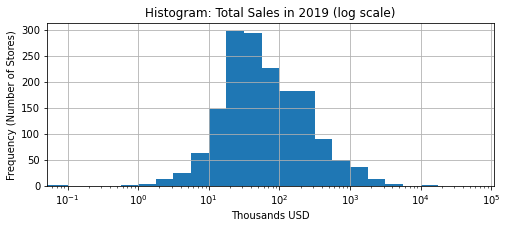

In [6]:
stores19_features = pd.read_pickle('stores19.pickle')
fig, ax = plt.subplots()
sales = stores19_features[('sum','Cents')]/100/1_000
sales.hist(
    ax=ax, bins=[0]+[10**(i/4) for i in range(-4,20)],
    figsize=(8,3))
ax.set_xscale('log')
ax.set_xlabel('Thousands USD')
ax.set_ylabel('Frequency (Number of Stores)')
ax.set_title('Histogram: Total Sales in 2019 (log scale)');

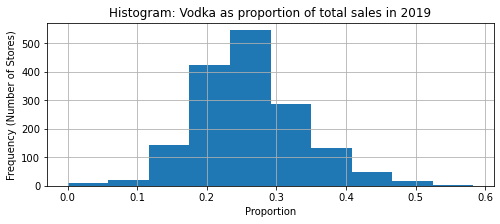

In [7]:
stores19_features = pd.read_pickle('stores19.pickle')
fig, ax = plt.subplots()

pc_vodka = stores19_features[('Cents_pc','Vodka')]
pc_vodka.hist(ax=ax, figsize=(8,3))

ax.set_xlabel('Proportion')
ax.set_ylabel('Frequency (Number of Stores)')
ax.set_title('Histogram: Vodka as proportion of total sales in 2019');

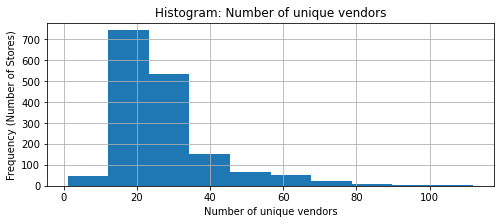

In [8]:
stores19_features = pd.read_pickle('stores19.pickle')
fig, ax = plt.subplots()

unique_vendors = stores19_features[('nunique','Vendor_num')]
unique_vendors.hist(ax=ax, figsize=(8,3))

ax.set_xlabel('Number of unique vendors')
ax.set_ylabel('Frequency (Number of Stores)')
ax.set_title('Histogram: Number of unique vendors');

Text(0.5, 1.0, 'Histogram: Average retail sales price ($/gal)')

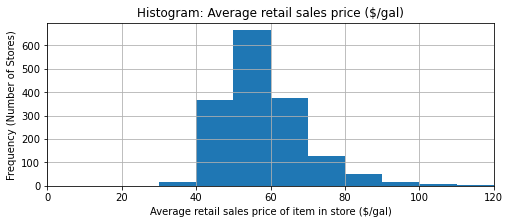

<IPython.core.display.Javascript object>

CPU times: user 299 ms, sys: 17.8 ms, total: 317 ms
Wall time: 343 ms


In [9]:
%%time
%%notify

stores19_features = pd.read_pickle('stores19.pickle')
fig, ax = plt.subplots()

dol_per_gal = stores19_features[('Dol_per_gal','All')]
dol_per_gal.hist(ax=ax, figsize=(8,3), bins=[10*i for i in range(2,14)])

ax.set_xlim(0,120)

ax.set_xlabel('Average retail sales price of item in store ($/gal)')
ax.set_ylabel('Frequency (Number of Stores)')
ax.set_title('Histogram: Average retail sales price ($/gal)');